# MVP 1: Baseline Object-Centric Event Stream Processing with Offline Discovery
## This notebook show functionalities of the first MVP of the project, which focuses on offline discovery of object-centric event streams.

Key changes:
1. `sources/` now accommodates .jsonocel files
2. `boevent.py` is a beamline object event that represents a single object-centric event in a stream.
3. `abstractevent.py` is an abstract base class for events, defining the interface for event objects as similariies between the two event types exists.


Extensions:
1. `sources/` add more input formats

In [1]:
import importlib
import pybeamline  # replace with your module name
importlib.reload(pybeamline)
from pm4py import view_ocpn, view_ocdfg
from reactivex.operators import window_with_count
from reactivex import operators as ops
from pm4py.algo.discovery.ocel.ocdfg import algorithm as ocdfg_discovery
from pm4py.algo.discovery.ocel.ocpn import algorithm as ocpn_discovery
from pybeamline.mappers.sliding_window_to_ocel import sliding_window_to_ocel
from pybeamline.sources.ocel_json_log_source import ocel_json_log_source_from_file


In [2]:
# Load jsonocel file
log_source = ocel_json_log_source_from_file('../../tests/logistics.jsonocel')

# only print first 10 events
i = 0
def print_event(event):
    global i
    if i < 10:
        print(event)
        i += 1

log_source.pipe().subscribe(
    lambda x: print_event(x)
)


(reg_co1, Register Customer Order, 2023-05-22 11:54:42+00:00, [{'ocel:oid': 'co1', 'ocel:type': 'Customer Order'}])
(reg_co2, Register Customer Order, 2023-05-22 18:33:30+00:00, [{'ocel:oid': 'co2', 'ocel:type': 'Customer Order'}])
(create_td1, Create Transport Document, 2023-05-23 08:22:17+00:00, [{'ocel:oid': 'co2', 'ocel:type': 'Customer Order'}, {'ocel:oid': 'td1', 'ocel:type': 'Transport Document'}])
(book_vehs_td1, Book Vehicles, 2023-05-23 10:05:16+00:00, [{'ocel:oid': 'td1', 'ocel:type': 'Transport Document'}, {'ocel:oid': 'vh4', 'ocel:type': 'Vehicle'}, {'ocel:oid': 'vh1', 'ocel:type': 'Vehicle'}])
(reg_co3, Register Customer Order, 2023-05-23 12:14:57+00:00, [{'ocel:oid': 'co3', 'ocel:type': 'Customer Order'}])
(order_crs_td1, Order Empty Containers, 2023-05-23 13:22:08+00:00, [{'ocel:oid': 'td1', 'ocel:type': 'Transport Document'}, {'ocel:oid': 'cr3', 'ocel:type': 'Container'}, {'ocel:oid': 'cr5', 'ocel:type': 'Container'}, {'ocel:oid': 'cr1', 'ocel:type': 'Container'}, {'oc

In [3]:
# Sliding window of 1000 events
# only print summary of first 1000 events ocel event log
j = 0
def print_summary(ocel):
    global j
    if j < 1:
        print(ocel.get_summary())
        j = 1

# Pm4py OCEL object integration
log_source.pipe(
    window_with_count(1000),
    sliding_window_to_ocel(),
).subscribe(lambda ocel: print_summary(ocel))

Object-Centric Event Log (number of events: 1000, number of objects: 467, number of activities: 13, number of object types: 7, events-objects relationships: 2013)
Activities occurrences: Counter({'Collect Goods': 310, 'Load Truck': 309, 'Pick Up Empty Container': 64, 'Drive to Terminal': 58, 'Weigh': 56, 'Place in Stock': 55, 'Register Customer Order': 27, 'Create Transport Document': 26, 'Book Vehicles': 26, 'Order Empty Containers': 23, 'Bring to Loading Bay': 22, 'Load to Vehicle': 20, 'Depart': 4})
Object types occurrences (number of objects): Counter({'Handling Unit': 310, 'Container': 84, 'Customer Order': 27, 'Transport Document': 26, 'Vehicle': 11, 'Truck': 6, 'Forklift': 3})
Unique activities per object type: Counter({'Container': 9, 'Forklift': 4, 'Transport Document': 4, 'Vehicle': 3, 'Customer Order': 2, 'Handling Unit': 2, 'Truck': 2})
Please use <THIS>.get_extended_table() to get a dataframe representation of the events related to the objects.


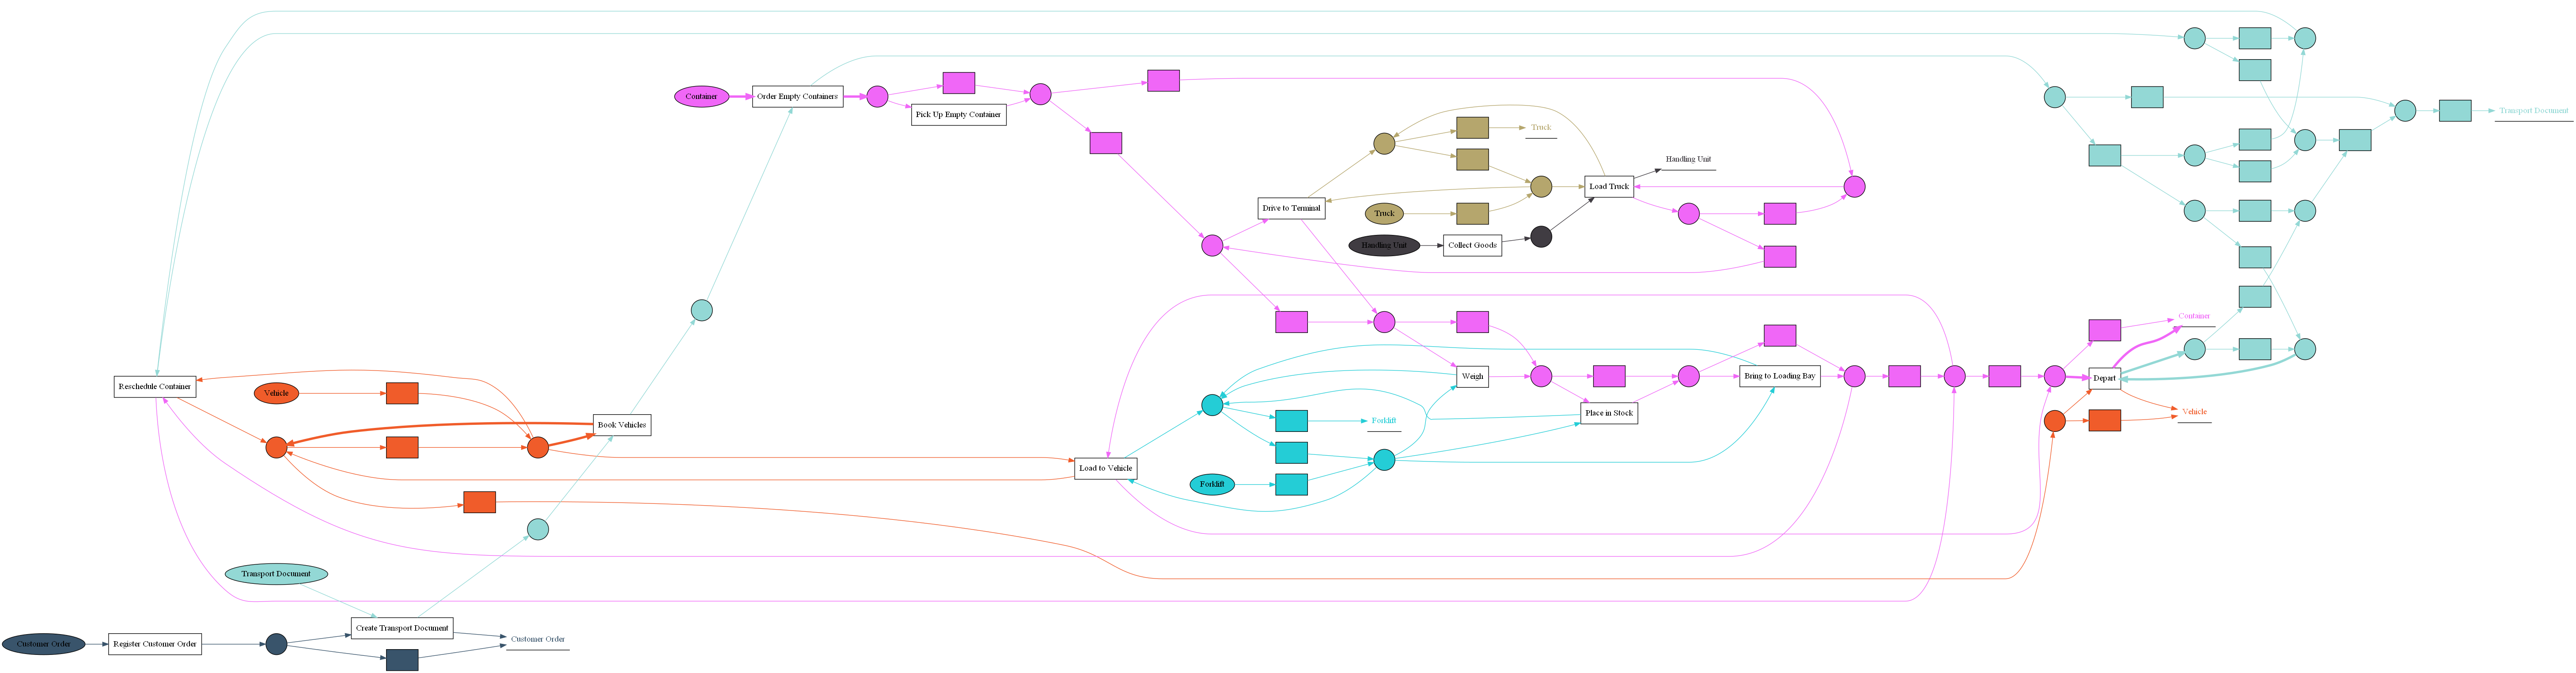

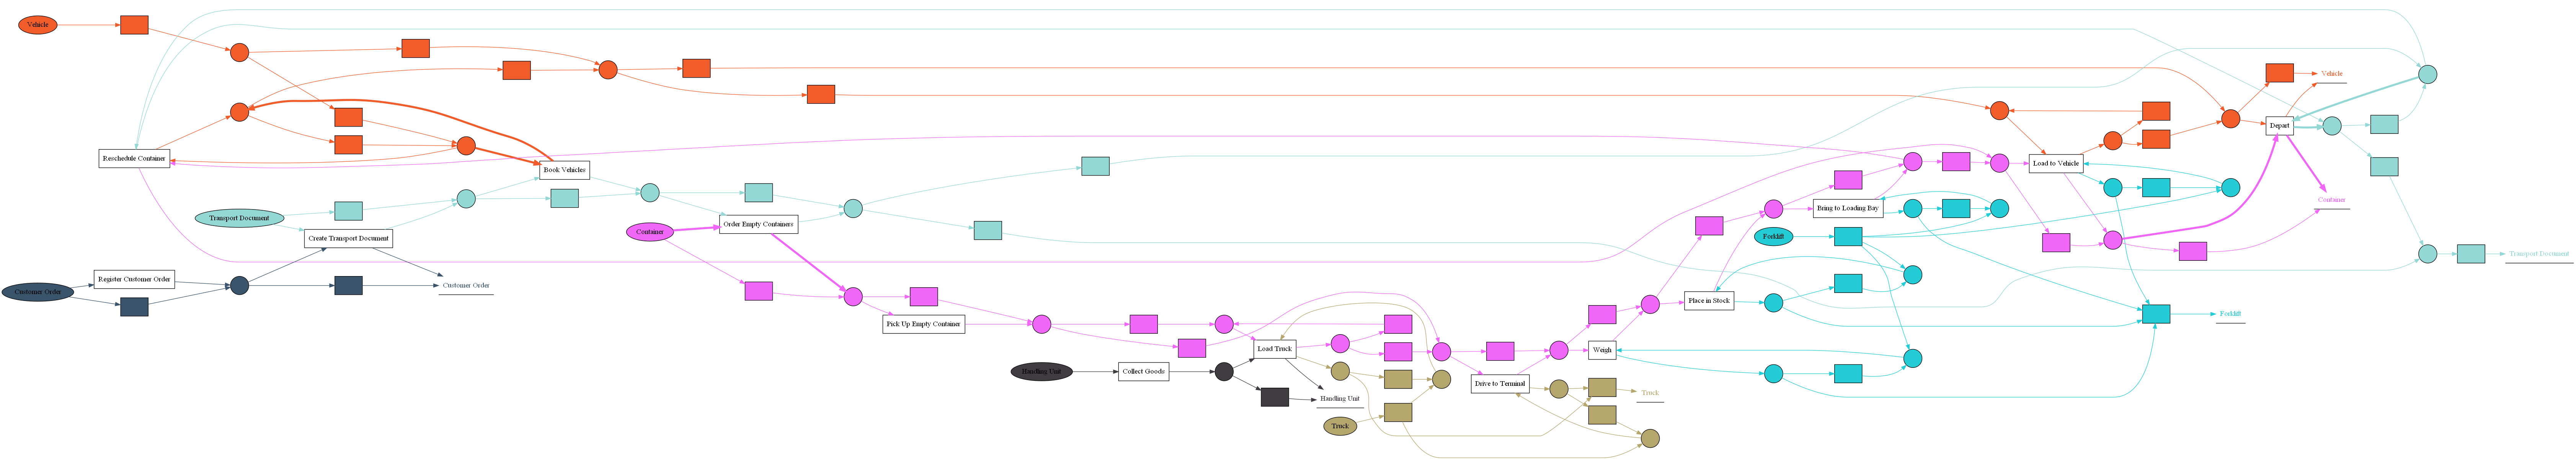

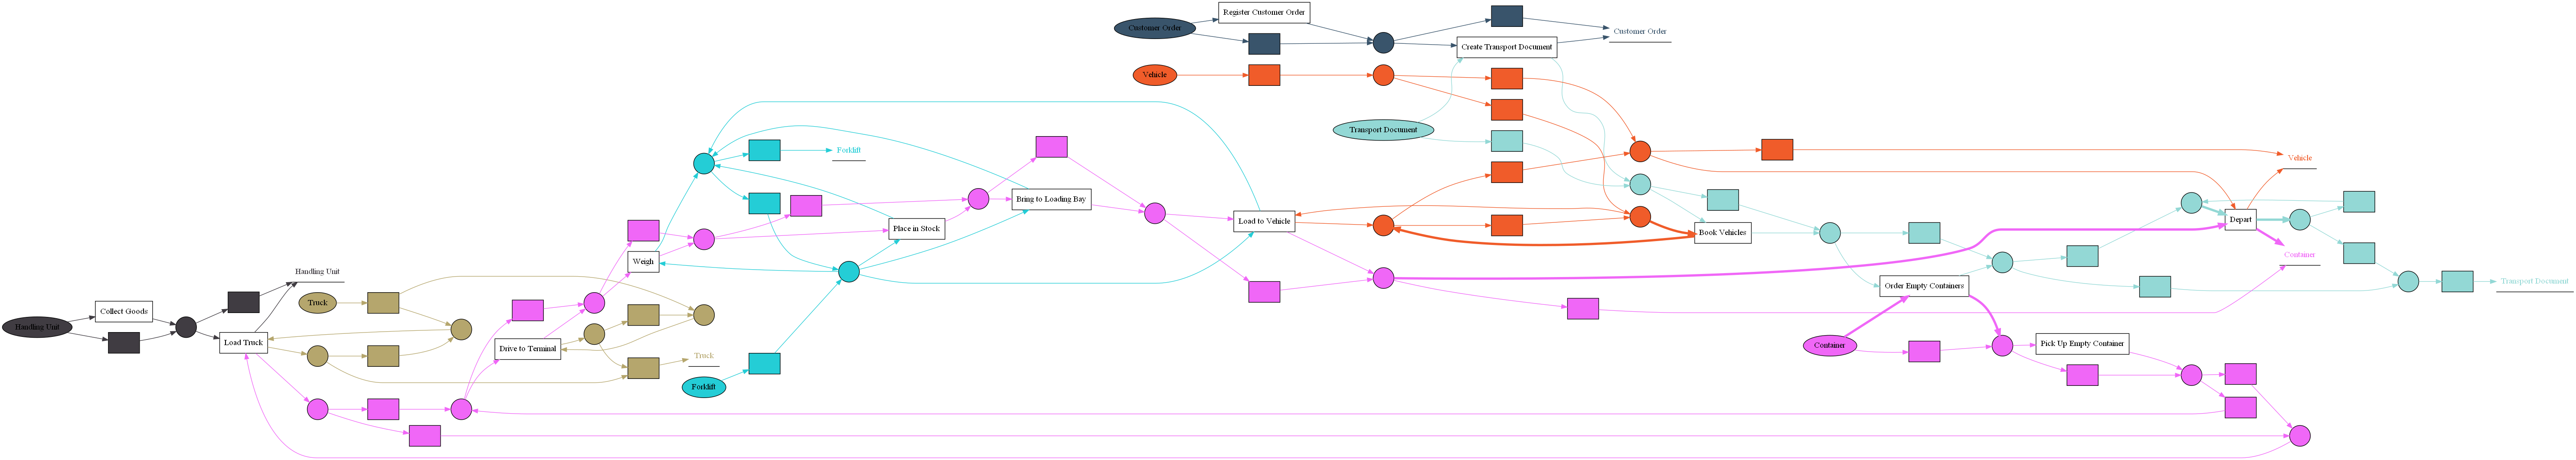

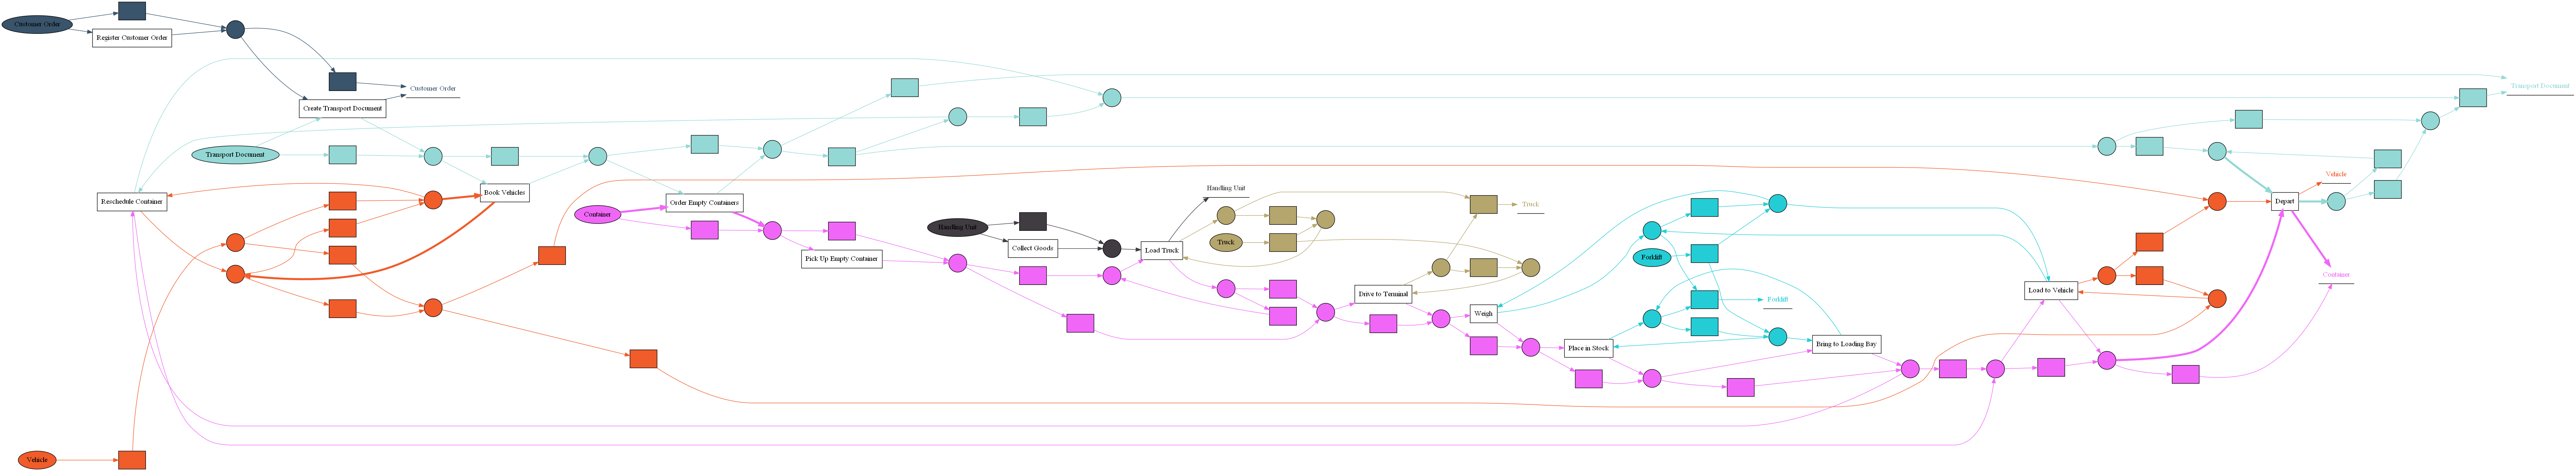

In [4]:
# Pm4py OCEL object centric petri net discovery
log_source.pipe(
    window_with_count(10000),
    sliding_window_to_ocel(),
    ops.map(lambda ocel: ocpn_discovery.apply(ocel))
).subscribe(lambda ocpn: view_ocpn(ocpn))

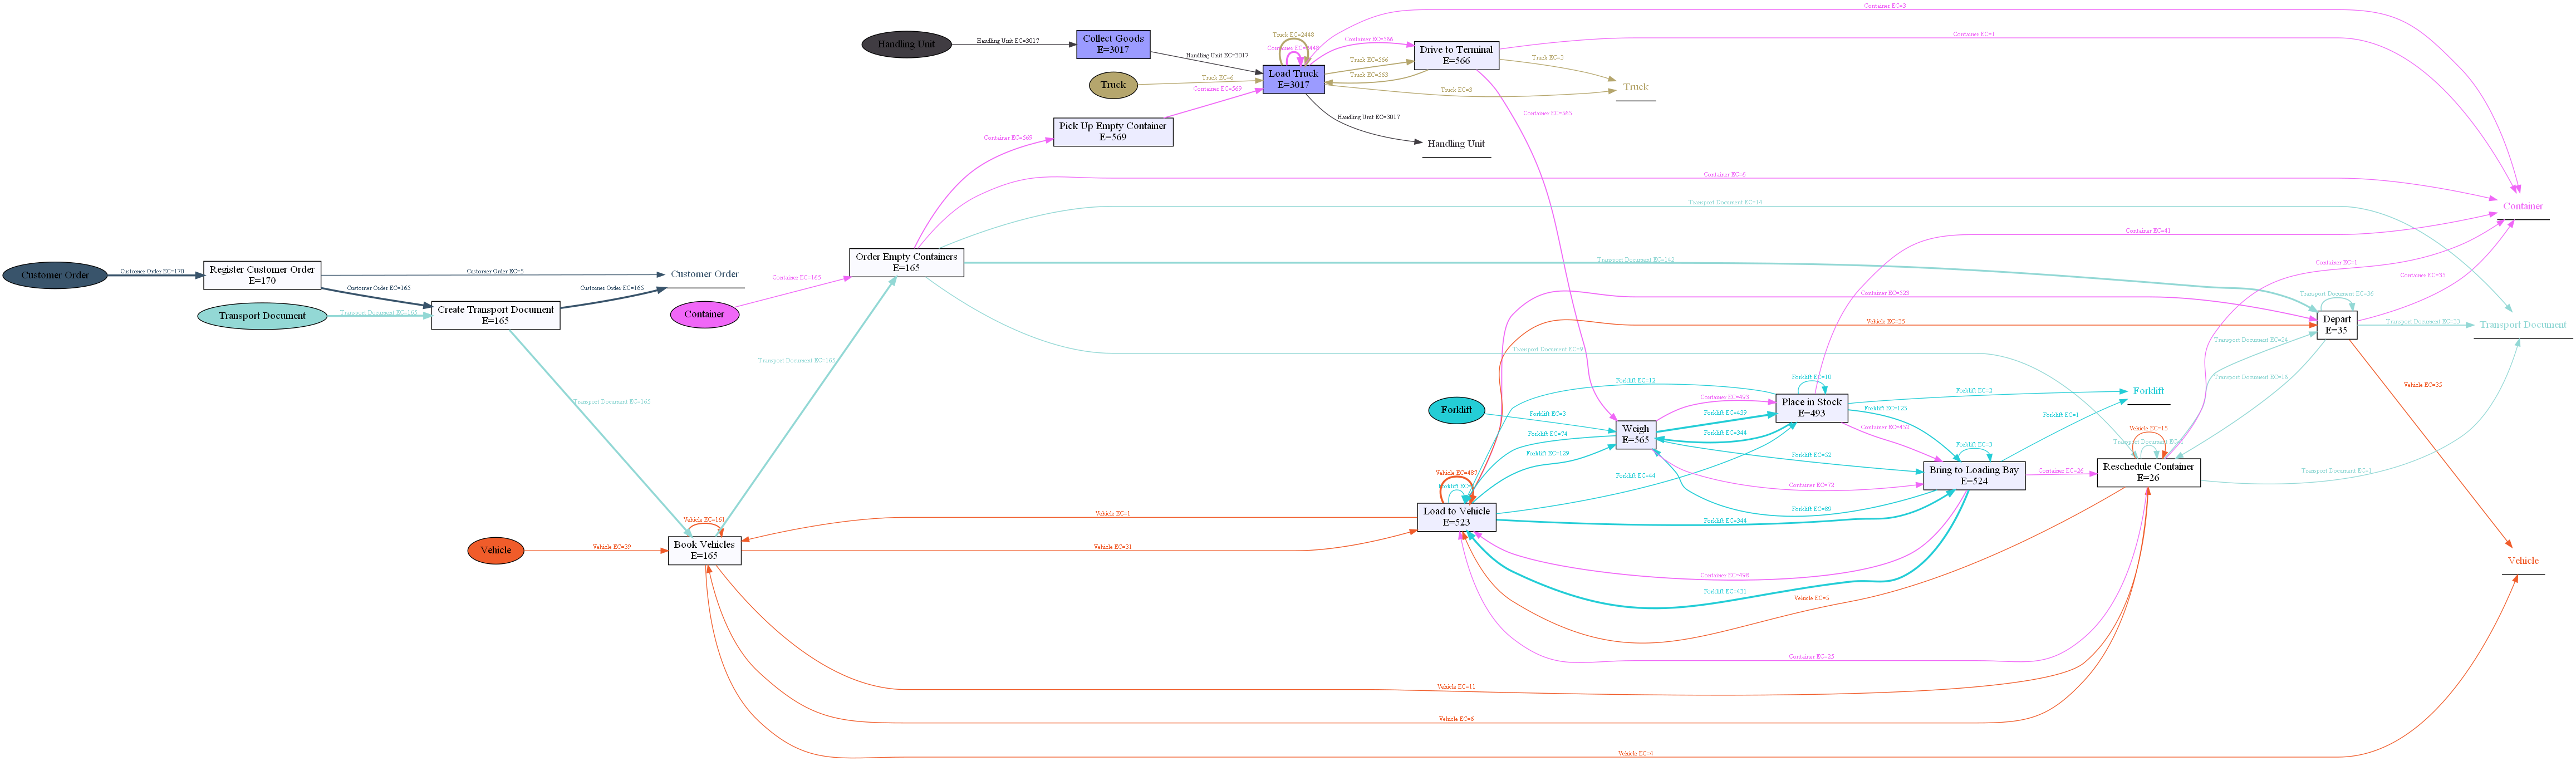

In [5]:


# Pm4py OCEL object centric direct follower graph discovery
h = 0
def view_one(ocdfg):
    global h
    if h < 1:
        view_ocdfg(ocdfg)
        h = h + 1

log_source.pipe(
    window_with_count(10000),
    sliding_window_to_ocel(),
    ops.map(lambda ocel: ocdfg_discovery.apply(ocel))
).subscribe(lambda ocdfg: view_one(ocdfg))

# Integration with River for Concept Drift Detection

## Experimental Setup
In this test environment, we simulate and compare two distinct process variants:
- **Traditional Service Workflow**: A non-digitalized flow involving manual steps.
- **Digitalized Service Workflow**: A more modern flow involving digital interactions such as license activation and download links.

The two flows are mixed and streamed as object-centric event data. We apply a pattern detector to track the frequency of a specific object-centric behavior—in this case, the transition from **"Approve Order"** to **"Pack Items"** for the same object.

We then use **ADWIN** (Adaptive Windowing), a concept drift detector from the `river` library, to monitor frequency changes of this pattern over time.

## Key Observations
- The digitalized workflow gradually becomes dominant in the stream.
- This shift is reflected as a **drift** in the pattern frequency curve.
- Red vertical lines in the plot indicate the windows where drift is detected.

##  Notes
- The pattern being tracked may be rare or absent in one of the flows.
- The approach is generalizable to other object-centric patterns and drift types (e.g., synchronization, lifecycle changes, object population shifts).

This experiment demonstrates how **object-centric streaming process mining** combined with **online drift detection** enables real-time insights into evolving process behaviors.


Drift detected at window index 1600 (pattern count: 1)
Drift detected at window index 3168 (pattern count: 7)


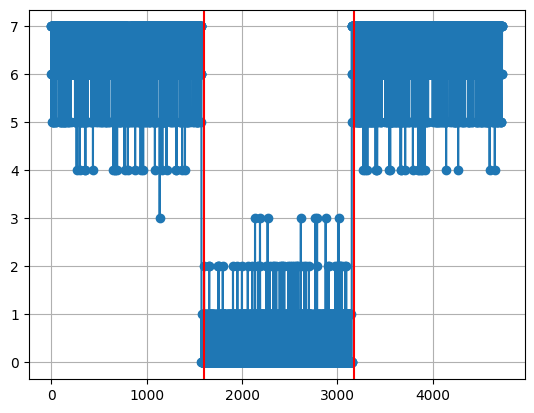

In [6]:
import reactivex
from pybeamline.sources.dict_ocel_test_source import dict_test_ocel_source
from river import drift
from reactivex import operators as ops
import matplotlib.pyplot as plt


Non_digitalized_service = [
    {"activity": "Create Order", "objects": {"Order": ["o1"]}},
    {"activity": "Add Item", "objects": {"Order": ["o1"], "Item": ["i1"]}},
    {"activity": "Approve Order", "objects": {"Order": ["o1"]}},
    {"activity": "Pack Items", "objects": {"Order": ["o1"], "Item": ["i1"], "Package": ["p1"]}},
    {"activity": "Ship Order", "objects": {"Order": ["o1"], "Shipment": ["s1"]}},
    {"activity": "Invoice Order", "objects": {"Order": ["o1"], "Invoice": ["inv1"]}},
]

digitalized_service = [
    {"activity": "Create Order", "objects": {"Order": ["o2"]}},
    {"activity": "Add Digital Product", "objects": {"Order": ["o2"], "DigitalItem": ["di1"]}},
    {"activity": "Approve Order", "objects": {"Order": ["o2"]}},
    {"activity": "Activate License", "objects": {"Order": ["o2"], "DigitalItem": ["di1"], "License": ["lic1"]}},
    {"activity": "Send Download Link", "objects": {"Order": ["o2"], "DigitalItem": ["di1"]}},
    {"activity": "Invoice Order", "objects": {"Order": ["o2"], "Invoice": ["inv2"]}},
]

log_without_drift = dict_test_ocel_source([(Non_digitalized_service, 10000), (digitalized_service, 500)], shuffle=True)

log_with_drift = dict_test_ocel_source([(Non_digitalized_service, 500), (digitalized_service, 10000)], shuffle=True)
combined_log = log_without_drift + log_with_drift + log_without_drift

pattern = ("Approve Order", "Pack Items")


drift_detector = drift.ADWIN()
data = []
drifts = []

def check_for_drift():
    index = 0
    def _process(x):
        nonlocal index
        drift_detector.update(x)
        index += 1
        if drift_detector.drift_detected:
            drifts.append(index)
            print(f"Drift detected at window index {index} (pattern count: {x})")
    return ops.do_action(_process)



combined_log.pipe(
    ops.buffer_with_count(40),
    #ops.do_action(lambda x: print(f"🧩 Buffered window: {x}")),
    ops.flat_map(lambda events: reactivex.from_iterable(events).pipe(
        ops.pairwise(),
        ops.filter(lambda pair: any(obj in pair[0].get_object_ids() for obj in pair[1].get_object_ids())
                        and pair[0].get_event_name() == pattern[0] and pair[1].get_event_name() == pattern[1]),
        ops.count()
        )
    ),
    check_for_drift()
).subscribe(lambda x: data.append(x))


plt.plot(data, marker='o')
plt.grid()
for drift_detected in drifts:
    plt.axvline(drift_detected, color='red')
plt.show()

## Extension: Streaming Context Awareness with Object-Centric Logs
Building on the previous concept drift detection setup, we now explore how object-centric event streams empower context-sensitive analysis. Instead of just detecting changes in control-flow (e.g., activity sequences), we now look at how contextual properties of objects evolve over time—enabling real-time understanding of deeper behavioral patterns.

### Scenario: Sales Trend Data Detection via Object Drift
Consider two evolving process variants in a retail setting:

Baseline Behavior: Each customer purchases a small, fixed number of grocery items.

Emerging Behavior: Over time, customers increasingly add more groceries per transaction.

By modeling this in **object-centric logs**, where each event references multiple object types (e.g., Customer, GroceryItem), we can stream these interactions and monitor how the number of groceries per customer shifts across windows.

With tools like ADWIN applied to a relevant metric (e.g., number of GroceryItem objects per Customer in a window), we can detect when a statistically significant trend change occurs—such as a seasonal spike or promotion-driven surge in grocery purchases.

**Why This Matters**:
1. This goes beyond control-flow analysis by observing object distribution dynamics.
2. It enables early detection of market trends, behavioral shifts, or operational changes.
3. This can inform personalized recommendations, inventory planning, or customer engagement strategies—in real-time.

Drift detected at window index 224 (pattern count: 26)


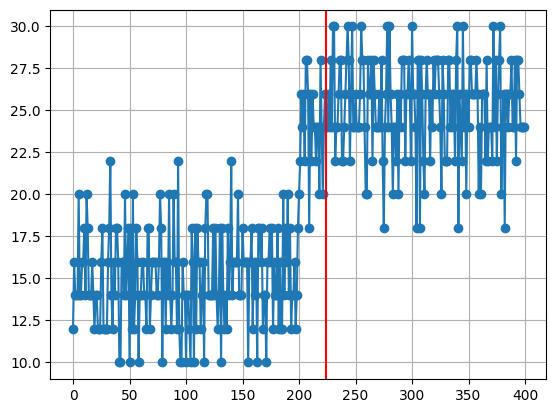

In [34]:
test_events_few_groceries = [
    {"activity": "Create Cart", "objects": {"Customer": ["c1"]}},
    {"activity": "Add Items", "objects": {"Customer": ["c1"], "GroceryItem": ["g1"]}},
    {"activity": "Checkout", "objects": {"Customer": ["c1"], "Cart": ["cart1"]}},
]

test_events_more_groceries = [
    {"activity": "Create Cart", "objects": {"Customer": ["c2"]}},
    {"activity": "Add Items", "objects": {"Customer": ["c2"], "GroceryItem": ["g1", "g2", "g3"]}},
    {"activity": "Checkout", "objects": {"Customer": ["c2"], "Cart": ["cart2"]}},
]

log_without_drift = dict_test_ocel_source([(test_events_few_groceries, 1500), (test_events_more_groceries, 500)], shuffle=True)

log_with_drift = dict_test_ocel_source([(test_events_few_groceries, 500), (test_events_more_groceries, 1500)], shuffle=True)
combined_log = log_without_drift + log_with_drift

drift_detector = drift.ADWIN()
data = []
drifts = []

def check_for_drift():
    index = 0
    def _process(x):
        nonlocal index
        drift_detector.update(x)
        index += 1
        if drift_detector.drift_detected:
            drifts.append(index)
            print(f"Drift detected at window index {index} (pattern count: {x})")
    return ops.do_action(_process)

combined_log.pipe(
    ops.buffer_with_count(30),
    ops.map(lambda events: [
        obj
        for event in events if event.get_event_name() == "Add Items"
        for obj in event.get_object_refs()
        if obj["ocel:type"] == "GroceryItem"
    ]),
    ops.map(len),
    check_for_drift()
).subscribe(lambda count: data.append(count))

plt.plot(data, marker='o')
plt.grid()
for drift_detected in drifts:
    plt.axvline(drift_detected, color='red')
plt.show()
